# DTSA 5509 Supervised Learning Final Project
## Decision Tree Binary Classification Tasks Applied to Food Access Research Atlas
### Project Topic
Food Deserts are areas where there is low access to supermarkets and other sources of healthy foods. They are often reported as occuring in communities that are already underserved, low income, and in Black communities. Access to food that is affordable and healthy is critical to support the health and wellbeing of a community, and areas that are struggling with poverty and inequality often also struggle with basic access to healthy food.

Understanding the circumstances that create food deserts is critical in being able to identify and address the root causes of the problem. If we can model this, we can make connections in the data we may not have seen otherwise.  We can also use this to predict outcomes as communities change.

Using socio-economic data from the Department of Agriculture's Food Access Research Atlas, I explored three decision tree binary classification models to attempt to classify whether a community is likely to have low access to healthy food sources.

**For more information**

Annie E. Casey Foundation: Food Deserts in the United States: https://www.aecf.org/blog/exploring-americas-food-deserts

Wikipedia: Food Desert: https://en.wikipedia.org/wiki/Food_desert

### Imports

In [50]:
import pandas as pd
import altair as alt
import dtale
from sklearn.svm import SVC
from xgboost import XGBClassifier
from xgboost import DMatrix
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import ttest_ind
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

### Data
The data used in this report is the Food Access Research Atlas, published by the Economic Research Service, Department of Agriculture, via data.gov, a public source of data made available by the United States government.

This dataset has 72,531 records, one for each U.S. Census tract.  The dataset includes 147 features for each tract, describing the tract, the population of the tract, demographic breakdowns of each tract (population Black, Seniors, Children, etc), and numerous measures on the food access for each tract.

For my task, I wanted to focus on how the socio-economic factors contribututed to whether a tract was likely to be classified as low access to food.  I limited the features used to the following:

| Field              | Description                                                                                                 |
|:-------------------|:------------------------------------------------------------------------------------------------------------|
| LILATracts_1And10  | **`Label`** Flag for low-income and low access when considering low accessibilty at 1 and 10 miles                      |
| State              | **`Feature`** State name                                                                                                  |
| Urban              | **`Feature`** Flag for urban tract                                                                                        |
| OHU2010            | **`Feature`** Occupied housing unit count from 2010 census                                                                |
| PovertyRate        | **`Feature`** Share of the tract population living with income at or below the Federal poverty thresholds for family size |
| MedianFamilyIncome | **`Feature`** Tract median family income                                                                                  |
| TractLOWI          | **`Feature`** Total count of low-income population in tract                                                               |
| TractKids          | **`Feature`** Total count of children age 0-17 in tract                                                                   |
| TractSeniors       | **`Feature`** Total count of seniors age 65+ in tract                                                                     |
| TractWhite         | **`Feature`** Total count of White population in tract                                                                    |
| TractBlack         | **`Feature`** Total count of Black or African American population in tract                                                |
| TractAsian         | **`Feature`** Total count of Asian population in tract                                                                    |
| TractNHOPI         | **`Feature`** Total count of Native Hawaiian and Other Pacific Islander population in tract                               |
| TractAIAN          | **`Feature`** Total count of American Indian and Alaska Native population in tract                                        |
| TractOMultir       | **`Feature`** Total count of Other/Multiple race population in tract                                                      |
| TractHispanic      | **`Feature`** Total count of Hispanic or Latino population in tract                                                       |
| TractHUNV          | **`Feature`** Total count of housing units without a vehicle in tract                                                     |
| TractSNAP          | **`Feature`** Total count of housing units receiving SNAP benefits in tract                                               |

Field `LILATracts_1And10` is the label I'm attempting to predict.  The remaining fields are features.


Data: https://catalog.data.gov/dataset/food-access-research-atlas

About the Atlas: https://www.ers.usda.gov/data-products/food-access-research-atlas/about-the-atlas.aspx

In addition, I'm using the U.S. Census Divisions listed at the following URL to perform further feature engineering to supplement my dataset.

https://www.ncei.noaa.gov/access/monitoring/reference-maps/us-census-divisions

**Data Citations**

Economic Research Service, Department of Agriculture (2021, February 24). Data.Gov. Food Access Research Atlas. Retrieved April 23, 2023, from https://catalog.data.gov/dataset/food-access-research-atlas

In [2]:
label = 'LILATracts_1And10'

In [3]:
# Create variable table and copy to clipboard for above
used_columns = [label,'Pop2010','State','OHU2010','Urban','PovertyRate','MedianFamilyIncome','TractBlack','TractLOWI','TractKids','TractSeniors','TractWhite','TractAsian','TractNHOPI','TractAIAN','TractOMultir','TractHispanic','TractHUNV','TractSNAP']
var_df = pd.read_excel('../data/FoodAccessResearchAtlasData2019.xlsx', sheet_name='Variable Lookup')
var_df = var_df[var_df['Field'].isin(used_columns)][['Field','Description']]
#pd.io.clipboards.to_clipboard(var_df.to_markdown(index=False), excel=False)

### Data Cleaning

As outlined above, I've limited the features used to the most relevant features for the classification task I wanted to perform.  Of the 147 features, 18 are relevant for the task of classifying the low food access status based on the demographic makeup of an area.  Many of the other features in the original file describe in detail the low food access for specific populations, so have been left out since they would be auto-correlative with the low access label I'm attempting to predict.

In addition, while reviewing the number of NA values present in the data, I found that `MedianFamilyIncome` had a high count of NAs. I have dropped this feature from the dataset for this reason.

`OHU2010` has values of 0 for 106 rows. This appears to be null data, coded as 0.  As this will cause a division by 0 error when calculating percentages below, I'm also dropping these rows.

The remaining features have a low number of NA values.  For these, I have dropped the rows that contained NA values.

In the original dataset, the demographic data is reported as total counts of residents in that demographic. Because I want to compare tracts, and each tract may have a different total population, it makes most sense to convert these to percentages.  Below, I calculate the percentage of residents in each demographic using the demographic count and the total population count `Pop2010`.  After I've done these calculations, I drop the original count columns as they are no longer needed.

I also investigated whether the labels in the dataset were balanced.  I've found that they are not, and I rebalance these later while building the model.

#### Read Data
Load the data into a dataframe

In [4]:
# Read Data
df = pd.read_excel('../data/FoodAccessResearchAtlasData2019.xlsx', sheet_name='Food Access Research Atlas')
df = df[used_columns]

#### Data Types Check
Reviewing the dtypes listed below, these are as I would expect them to be.  I do not believe any data type munging is necessary for this dataset.

In [37]:
df.dtypes

LILATracts_1And10      int64
State                 object
Urban                  int64
PovertyRate          float64
BlackPopShare        float64
LOWIPopShare         float64
KidsPopShare         float64
SeniorsPopShare      float64
WhitePopShare        float64
AsianPopShare        float64
NHOPIPopShare        float64
AIANPopShare         float64
OMultirPopShare      float64
HispanicPopShare     float64
HUNVPopShare         float64
SNAPPopShare         float64
Census Division       object
dtype: object

#### Check for NAs and Vizualize
Check for explicit nas in the dataset

In [5]:
# Check for NAs
na_counts = pd.DataFrame(df.isna().sum()).reset_index()
na_counts.columns = ['Field', 'NA Count']
na_counts = na_counts.sort_values('NA Count', ascending=False)

# Visualize NAs
base = alt.Chart(na_counts).encode(
    x=alt.X('Field:N', sort='-y'),
    y='NA Count',
    text = 'NA Count'
).properties(width=800)
base.mark_bar() + base.mark_text(align='center', dy=-10)

alt.LayerChart(...)

#### Drop NAs
Dropping explicit NAs from the dataset

In [6]:
len_df_bef = len(df)

# Drop high NA column Median Family Income
df = df.drop('MedianFamilyIncome', axis=1)

# Drop records with NAs in values
df = df.dropna()
print(str(len_df_bef - len(df)) + ' rows dropped')

# Check for no remaining NAs
print('Remaining NAs:')
display(df.isna().sum())

4 rows dropped
Remaining NAs:


LILATracts_1And10    0
Pop2010              0
State                0
OHU2010              0
Urban                0
PovertyRate          0
TractBlack           0
TractLOWI            0
TractKids            0
TractSeniors         0
TractWhite           0
TractAsian           0
TractNHOPI           0
TractAIAN            0
TractOMultir         0
TractHispanic        0
TractHUNV            0
TractSNAP            0
dtype: int64

#### Drop 0-coded NAs
Dropping missing data that is coded as 0 in the dataset

In [7]:
len_df_bef = len(df)

# Check count of 0 values where we expect > 0
print('Count of 0 values for Pop2010: {}'.format(sum(df['Pop2010'] == 0)))
print('Count of 0 values for OHU2010: {}'.format(sum(df['OHU2010'] == 0)))

# Keep only rows where values > 0
df = df[df['Pop2010'] > 0]
df = df[df['OHU2010'] > 0]
print(str(len_df_bef - len(df)) + ' rows dropped')

# Check our work
print('Count of 0 values for Pop2010: {}'.format(sum(df['Pop2010'] == 0)))
print('Count of 0 values for OHU2010: {}'.format(sum(df['OHU2010'] == 0)))

Count of 0 values for Pop2010: 0
Count of 0 values for OHU2010: 106
106 rows dropped
Count of 0 values for Pop2010: 0
Count of 0 values for OHU2010: 0


#### Check for Label Imbalance
Checking for label imbalance here. There is a clear imbalance in the data.  We'll account for the label imbalance later, when building our model.

In [8]:
# Check for imbalaced labels
val_counts = pd.DataFrame(df[label].value_counts()).reset_index()
base = alt.Chart(val_counts).encode(
    x=alt.X(label + ':N', sort='-y'),
    y='count',
    text = 'count'
).properties(width=100)
base.mark_bar(size=30) + base.mark_text(align='center', dy=-10)

alt.LayerChart(...)

### Feature Engineering

#### Calculate Percentage Share for Each Demographic
In order to compare tract to tract, where total populations may differ, I calculated the percentage makeup of each population and stored it back into my dataset.  These engineered features will make up a majority of the features used in the model.

In [9]:
# Calculate percentage share for each demographic population
df['BlackPopShare'] = df['TractBlack'] / df['Pop2010']
df['LOWIPopShare'] = df['TractLOWI'] / df['Pop2010']
df['KidsPopShare'] = df['TractKids'] / df['Pop2010']
df['SeniorsPopShare'] = df['TractSeniors'] / df['Pop2010']
df['WhitePopShare'] = df['TractWhite'] / df['Pop2010']
df['AsianPopShare'] = df['TractAsian'] / df['Pop2010']
df['NHOPIPopShare'] = df['TractNHOPI'] / df['Pop2010']
df['AIANPopShare'] = df['TractAIAN'] / df['Pop2010']
df['OMultirPopShare'] = df['TractOMultir'] / df['Pop2010']
df['HispanicPopShare'] = df['TractHispanic'] / df['Pop2010']
df['HUNVPopShare'] = df['TractHUNV'] / df['OHU2010']
df['SNAPPopShare'] = df['TractSNAP'] / df['OHU2010']

# Drop the original features, since we don't need them any more
df = df.drop(['Pop2010','OHU2010','TractBlack','TractLOWI','TractKids','TractSeniors','TractWhite','TractAsian','TractNHOPI','TractAIAN','TractOMultir','TractHispanic','TractHUNV','TractSNAP'], axis=1)

#### Add U.S Census Divisions to Data
In Exploratory Data Analysis below, I found evidence that certain regions of the U.S. may have more low income, low access trackts than others.  Here, I map state to regions, based on the assigned region names from the U.S. Census Regions mapping described in the Data section above.

In [10]:
div_map = {
    'Illinois':'East North Central',
    'Indiana':'East North Central',
    'Michigan':'East North Central',
    'Ohio':'East North Central',
    'Wisconsin':'East North Central',
    'Alabama':'East South Central',
    'Kentucky':'East South Central',
    'Mississippi':'East South Central',
    'Tennessee':'East South Central',
    'New Jersey':'Middle Atlantic',
    'New York':'Middle Atlantic',
    'Pennsylvania':'Middle Atlantic',
    'Arizona':'Mountain',
    'Colorado':'Mountain',
    'Idaho':'Mountain',
    'Montana':'Mountain',
    'New Mexico':'Mountain',
    'Nevada':'Mountain',
    'Utah':'Mountain',
    'Wyoming':'Mountain',
    'Connecticut':'New England',
    'Maine':'New England',
    'Massachusetts':'New England',
    'New Hampshire':'New England',
    'Rhode Island':'New England',
    'Vermont':'New England',
    'California':'Pacific',
    'Oregon':'Pacific',
    'Washington':'Pacific',
    'Delaware':'South Atlantic',
    'Florida':'South Atlantic',
    'Georgia':'South Atlantic',
    'Maryland':'South Atlantic',
    'North Carolina':'South Atlantic',
    'South Carolina':'South Atlantic',
    'Virginia':'South Atlantic',
    'West Virginia':'South Atlantic',
    'Iowa':'West North Central',
    'Kansas':'West North Central',
    'Minnesota':'West North Central',
    'Missouri':'West North Central',
    'Nebraska':'West North Central',
    'North Dakota':'West North Central',
    'South Dakota':'West North Central',
    'Arkansas':'West South Central',
    'Louisiana':'West South Central',
    'Oklahoma':'West South Central',
    'Texas':'West South Central'
}
df['Census Division'] = df['State'].map(div_map)

### Exploratory Data Analysis

#### Correlation
Calculate and visualize a correlation matrix.

From the correlation matrix below, we can see a few interesting correlations:
- BlackPopShare is significantly negatively correlated with WhitePopShare. This specific strong correlation may point to these population numbers being good features for a binary classification model, with some more analysis on the correlation to to our label to follow.
- In addition, there is a negative correlation between WhitePopShare, LOWIPopShare (Low Income), PovertyRate, and SNAPPopShare.  There is a positive correlation between BlackPopShare and these same features. Since we suspect that low access, low income tracts may correlate to communities with higher poverty rate, etc, these correlations seem to suggest that they may be good indicators to identify feed desert communities.
- It's interesting that features like KidsPopShare appear to be positively correlated with PovertyRate and SNAPPopShare.  I would not have guessed this going into this analysis, but this may also be a good indicator for my models. 

In [11]:
# Calculate Correlations
eda_df = df.copy()
eda_df = eda_df.drop(['State', 'Census Division', 'LILATracts_1And10', 'Urban'], axis=1)
cor_data = (eda_df.corr().stack().reset_index() 
              .rename(columns={0: 'correlation', 'level_0': 'variable', 'level_1': 'variable2'}))
cor_data['correlation_label'] = cor_data['correlation'].map('{:.2f}'.format)

In [12]:
# Vizualize correlations
base = alt.Chart(cor_data).encode(
    x='variable2:O',
    y='variable:O'    
)

text = base.mark_text().encode(
    text='correlation_label',
    color=alt.condition(
        alt.datum.correlation > 0.5, 
        alt.value('white'),
        alt.value('black')
    )
)

cor_plot = base.mark_rect().encode(
    color=alt.Color('correlation:Q', scale=alt.Scale(scheme='redblue'))
).properties(width=600, height=600)

cor_plot + text

alt.LayerChart(...)

#### Differences in Population Means
Below, I explore the relationship between the population means when comparing populations that are low income and low access with populations that are not.

In [13]:
lila_1_black = df[df['LILATracts_1And10'] == 1]['BlackPopShare']
lila_0_black = df[df['LILATracts_1And10'] == 0]['BlackPopShare']
lila_1_white = df[df['LILATracts_1And10'] == 1]['WhitePopShare']
lila_0_white = df[df['LILATracts_1And10'] == 0]['WhitePopShare']
print('Low Access, Low Income: Black Population Mean: {:.2}'.format(lila_1_black.mean()))
print('Not Low Access, Low Income: Black Population Mean: {:.2}'.format(lila_0_black.mean()))
print('Low Access, Low Income: White Population Mean: {:.2}'.format(lila_1_white.mean()))
print('Not Low Access, Low Income: White Population Mean: {:.2}'.format(lila_0_white.mean()))

Low Access, Low Income: Black Population Mean: 0.23
Not Low Access, Low Income: Black Population Mean: 0.12
Low Access, Low Income: White Population Mean: 0.63
Not Low Access, Low Income: White Population Mean: 0.73


The means appear to suggest that, low access, low income communities have, on average, a higher percentage of Black population than thoese communities that are not low access, low income.

In addition, low access, low income communities have, on average, a lower percentage of White population than thoese communities that are not low access, low income.

This bears out in the following t-tests:

Test the null hypothesis that the population share means are equal for Black populations, vs. the alternative hypothesis that low access, low income populations have greater Black population means than non-low access, low income populations:

In [14]:
ttest_ind(lila_1_black.tolist(), lila_0_black.tolist(), equal_var=False, alternative='greater')

Ttest_indResult(statistic=36.07918837717623, pvalue=1.45167200558015e-269)

At a level of significance of .05, we reject the null hypothesis in favor of the alternative.

Test the null hypothesis that the population share means are equal for White populations, vs. the alternative hypothesis that low access, low income populations have lower White population means than non-low access, low income populations:

In [15]:
ttest_ind(lila_1_white.tolist(), lila_0_white.tolist(), equal_var=False, alternative='less')

Ttest_indResult(statistic=-32.08791001570348, pvalue=9.128973228515656e-217)

At a level of significance of .05, we reject the null hypothesis in favor of the alternative.

As a result of the above tests, we can likely say that Black and White population means will likely be good features for our binary classification model.

#### Population Demographics
Below, I further explore the population demographics as they relate to low access, low income communities.

In [16]:
bins = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]
names = ['0%-10%', '10%-20%', '20%-30%', '30%-40%', '40%-50%', '50%-60%', '60%-70%', '70%-80%', '80%-90%', '90%-100%']

##### White and Black Communites Compared
Extending from above, I visualized the relationship between White and Black population percentages, and number of low income, low access communities.  We can see clearly here that, as the White population percentage increases, the percentage of low income, low access communites decrease.  Contrasting that, as the Black population percentage increases, the percentage of low income, low access communities decrease.  This again supports our findings above, and also indicates these may be good indicators for our models.

In [17]:
# Segment and calulate Black and White population statistics
eda_df = df.copy()
eda_df['PopShareRange'] = pd.cut(eda_df['BlackPopShare'], bins, labels=names)
b = eda_df[['PopShareRange',label]].groupby(['PopShareRange'], as_index=False).aggregate({label:['sum','count', 'mean']})
b.columns = [f"{x}_{y}" for x, y in b.columns.to_flat_index()]
b['Demographic'] = 'Black'

eda_df['PopShareRange'] = pd.cut(eda_df['WhitePopShare'], bins, labels=names)
w = eda_df[['PopShareRange',label]].groupby(['PopShareRange'], as_index=False).aggregate({label:['sum','count', 'mean']})
w.columns = [f"{x}_{y}" for x, y in w.columns.to_flat_index()]
w['Demographic'] = 'White'

bw = pd.concat([b,w])

In [18]:
# Visualize
alt.Chart(bw).mark_bar(size=25).encode(
    x=alt.X('Demographic:N', title='', axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('LILATracts_1And10_mean:Q', axis=alt.Axis(format='%'), title='Percent Low Income, Low Access Tracts'),
    color='Demographic:N',
    column=alt.Column('PopShareRange_:O', title='Population Percentage Range')
).properties(
    height=300,
    width=60
).configure_axis(
    labelFontSize=13,
    titleFontSize=15
).configure_header(
    labelFontSize=13,
    titleFontSize=15,
    labelOrient='bottom',
    titleOrient='bottom'
)

alt.Chart(...)

##### KidsPopShare and Low Income, Low Access Communities
From the correlation matrix above, it seemed like KidsPopShare was an interesting feature.  Looking at this data a little closely, we do see that as the kids population increases, we do see a very sharp increase in low income, low access communities.  This, of course, drops to zero at 60%, because there is a logical limit in the percentage of kids vs. parents in any given community.

In [19]:
# Calculate KidsPopShare statistics
eda_df = df.copy()
eda_df['PopShareRange'] = pd.cut(eda_df['KidsPopShare'], bins, labels=names)
k = eda_df[['PopShareRange',label]].groupby(['PopShareRange'], as_index=False).aggregate({label:['sum','count', 'mean']})
k.columns = [f"{x}_{y}" for x, y in k.columns.to_flat_index()]

In [20]:
# Visualize
alt.Chart(k).mark_bar(size=25).encode(
    x=alt.X('PopShareRange_:O', title='Population Percentage Range', axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('LILATracts_1And10_mean:Q', axis=alt.Axis(format='%'), title='Percent Low Income, Low Access Tracts'),
).properties(
    height=300,
    width=600
).configure_axis(
    labelFontSize=13,
    titleFontSize=15
)

alt.Chart(...)

##### States and Low Income, Low Access Communities
I plotted the states and Low Income, Low Access communities below because I wanted to explore if there was any kind of geo-spacial relationship driving food desert communities.  Indeed, I did find that the states with the most low income, low access communities appeared to be in one region of the country, and the states with the lowest percentage of low income, low access communities appeared to be in another.  This prompted me to add geographic regions to my data as an engineered feature.

In [21]:
# Calculate State statistics
eda_df = df.copy()
k = eda_df[['State',label]].groupby(['State'], as_index=False).aggregate({label:['sum','count', 'mean']})
k.columns = [f"{x}_{y}" for x, y in k.columns.to_flat_index()]

In [22]:
# Visualize
alt.Chart(k).mark_bar(size=10).encode(
    y=alt.Y('State_:N', title='State', sort='-x'),
    x=alt.X('LILATracts_1And10_mean:Q', axis=alt.Axis(format='%'), title='Percent Low Income, Low Access Tracts'),
).properties(
    height=800,
    width=600
).configure_axis(
    labelFontSize=13,
    titleFontSize=15
)

alt.Chart(...)

##### Regions and Low Income, Low Access Communites
Extending from above, I plotted regions and their relationships to low income, low access communities.  What I noticed above does appear to be supported by the data.

In [23]:
# Calculate division statistics
eda_df = df.copy()
d = eda_df[['Census Division',label]].groupby(['Census Division'], as_index=False).aggregate({label:['sum','count', 'mean']})
d.columns = [f"{x}_{y}" for x, y in d.columns.to_flat_index()]

In [24]:
# Visualize
alt.Chart(d).mark_bar(size=20).encode(
    y=alt.Y('Census Division_:N', title='Census Division', sort='-x'),
    x=alt.X('LILATracts_1And10_mean:Q', axis=alt.Axis(format='%'), title='Percent Low Income, Low Access Tracts'),
).properties(
    height=300,
    width=600
).configure_axis(
    labelFontSize=13,
    titleFontSize=15
)

alt.Chart(...)

### Models

#### Test/Train Preparation
Below, I select the features to include in my dataset.

In addition, I incorporate my engineered feature `Census Division` into the training dataset.  Because this engineered feature is categorical, in order for it to be used properly in the model, I expand it into one binary True/False feature per division via Pandas' `get_dummies` method.

In [25]:
# Prepare data
data = df.loc[:, df.columns.isin(['PovertyRate','MedianFamilyIncome','LowIncomeTracts','BlackPopShare','LOWIPopShare','KidsPopShare','SeniorsPopShare','WhitePopShare','AsianPopShare','NHOPIPopShare','AIANPopShare','OMultirPopShare','HispanicPopShare','HUNVPopShare','SNAPPopShare'])]
# Expand the Urban feature into two:  Rural and Urban
data = pd.concat([data, pd.get_dummies(df['Urban'])], axis=1)
data = data.rename({0:'Rural', 1:'Urban'}, axis=1)
# Expand the Census Division feature into one True/False feature per Census Division value.
data = pd.concat([data, pd.get_dummies(df['Census Division'])], axis=1)
# Assign labels
labels = df[label]

Using the prepared data, I perform a train/test split, with 80% training data and 20% test data:

In [26]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels)
print('Training Features Count: {}  Training Labels Count: {}'.format(len(X_train), len(y_train)))
print('Training Labels=1 Count: {}  Training Labels=0 Count: {}'.format(sum(y_train == 1), sum(y_train == 0)))
print('Testing Features Count: {}  Testing Labels Count: {}'.format(len(X_test), len(y_test)))

Training Features Count: 57936  Training Labels Count: 57936
Training Labels=1 Count: 7431  Training Labels=0 Count: 50505
Testing Features Count: 14485  Testing Labels Count: 14485


Since, as we found in data cleaning and just above, the labels are not balanced, I rebalance using under sampling:

In [27]:
under_sampler = RandomUnderSampler()
X_res, y_res = under_sampler.fit_resample(X_train, y_train)

print('Resampled Training Features Count: {}  Resampled Training Labels Count: {}'.format(len(X_res), len(y_res)))
print('Resampled Training Labels=1 Count: {}  Resampled Training Labels=0 Count: {}'.format(sum(y_res == 1), sum(y_res == 0)))

Resampled Training Features Count: 14862  Resampled Training Labels Count: 14862
Resampled Training Labels=1 Count: 7431  Resampled Training Labels=0 Count: 7431


#### Decision Tree Classifier
Below, I start with training a simple Decision Tree Classifier

In [ ]:
dcs = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=50)
dcs.fit(X_res, y_res)

In [ ]:
# Calculate scores
y_pred = dcs.predict(X_test)
precision, recall, fbeta_score, support = precision_recall_fscore_support(y_test, y_pred, pos_label=1, average='binary')
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print('Precision: {:.2}  Recall: {:.2}  F1: {:.2}'.format(precision,recall,fbeta_score))
print('Accuracy: {:.2}'.format(accuracy))
print('ROC-AUC: {:.2}'.format(roc_auc))

These scores are not horrible, but we can do better.

#### AdaBoost
I move to using an AdaBoost model to see if we can get some better scores.

In [ ]:
ada = AdaBoostClassifier(learning_rate=1)
ada.fit(X_res, y_res)

In [ ]:
# Calculate scores
y_pred = ada.predict(X_test)
precision, recall, fbeta_score, support = precision_recall_fscore_support(y_test, y_pred, pos_label=1, average='binary')
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print('Precision: {:.2}  Recall: {:.2}  F1: {:.2}'.format(precision,recall,fbeta_score))
print('Accuracy: {:.2}'.format(accuracy))
print('ROC-AUC: {:.2}'.format(roc_auc))

I get similar scores with the AdaBoost model

#### XGBoost
Finally, I experiment with XGBoost, a model that was not covered in the course, however I've seen perform very well in practice.

I expended a bit more rigor with this model, including hyperparameter tuning using grid search.

In [ ]:
# Format the train/test data as XGBoost requires
dtrain = DMatrix(X_res, label=y_res)
dtest = DMatrix(X_test, label=y_test)
evallist = [(dtrain, 'train'), (dtest, 'eval')]

Below, I perform hyperparameter tuning using a Grid Search.  I'm using ROC-AUC as my scoring metric to determine the best model.  In all, 405 candidate models were trained to attempt to find the best model.

In [ ]:
# Set hyperparameters for search
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5, 10, 15]
        }

# Instatiate the XGBoost classifier and begin grid search
xgb = XGBClassifier(learning_rate=0.02, objective='binary:logistic', nthread=1)
search = GridSearchCV(xgb, params, scoring='roc_auc', n_jobs=4, verbose=0)
search.fit(X_res, y_res)

In [ ]:
print('Best ROC_AUC score: {:.2}'.format(search.best_score_))
print('Best parameters:')
print(search.best_params_)

In [ ]:
# Calculate scores
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
precision, recall, fbeta_score, support = precision_recall_fscore_support(y_test, y_pred, pos_label=1, average='binary')
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print('Precision: {:.2}  Recall: {:.2}  F1: {:.2}'.format(precision,recall,fbeta_score))
print('Accuracy: {:.2}'.format(accuracy))
print('ROC-AUC: {:.2}'.format(roc_auc))

In [ ]:
plot_importance(best_model)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

#### XGBoost, Again
It looks like some of my engineered features (Urban, Rural, and the Census Divisions) are all relatively low performance compared to the others. I'll try the model again, with these features removed.

In [28]:
# Prepare data
data = df.loc[:, df.columns.isin(['PovertyRate','MedianFamilyIncome','LowIncomeTracts','BlackPopShare','LOWIPopShare','KidsPopShare','SeniorsPopShare','WhitePopShare','AsianPopShare','NHOPIPopShare','AIANPopShare','OMultirPopShare','HispanicPopShare','HUNVPopShare','SNAPPopShare'])]
# Assign labels
labels = df[label]

Using the prepared data, I perform a train/test split, with 80% training data and 20% test data:

In [29]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels)
print('Training Features Count: {}  Training Labels Count: {}'.format(len(X_train), len(y_train)))
print('Training Labels=1 Count: {}  Training Labels=0 Count: {}'.format(sum(y_train == 1), sum(y_train == 0)))
print('Testing Features Count: {}  Testing Labels Count: {}'.format(len(X_test), len(y_test)))

Training Features Count: 57936  Training Labels Count: 57936
Training Labels=1 Count: 7431  Training Labels=0 Count: 50505
Testing Features Count: 14485  Testing Labels Count: 14485


Since, as we found in data cleaning and just above, the labels are not balanced, I rebalance using under sampling:

In [30]:
under_sampler = RandomUnderSampler()
X_res, y_res = under_sampler.fit_resample(X_train, y_train)

print('Resampled Training Features Count: {}  Resampled Training Labels Count: {}'.format(len(X_res), len(y_res)))
print('Resampled Training Labels=1 Count: {}  Resampled Training Labels=0 Count: {}'.format(sum(y_res == 1), sum(y_res == 0)))

Resampled Training Features Count: 14862  Resampled Training Labels Count: 14862
Resampled Training Labels=1 Count: 7431  Resampled Training Labels=0 Count: 7431


In [31]:
# Format the train/test data as XGBoost requires
dtrain = DMatrix(X_res, label=y_res)
dtest = DMatrix(X_test, label=y_test)
evallist = [(dtrain, 'train'), (dtest, 'eval')]

Below, I perform hyperparameter tuning using a Grid Search.  I'm using ROC-AUC as my scoring metric to determine the best model.  In all, 405 candidate models were trained to attempt to find the best model.

In [32]:
# Set hyperparameters for search
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5, 10, 15]
        }

# Instatiate the XGBoost classifier and begin grid search
xgb = XGBClassifier(learning_rate=0.02, objective='binary:logistic', nthread=1)
search_wo_eng = GridSearchCV(xgb, params, scoring='roc_auc', n_jobs=4, verbose=0)
search_wo_eng.fit(X_res, y_res)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.02, max_b...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=1,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5], 'max_depth': [5, 10, 15],
                         'min_child_weight': [1, 5, 10],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='roc_auc')

In [33]:
print('Best ROC_AUC score: {:.2}'.format(search_wo_eng.best_score_))
print('Best parameters:')
print(search_wo_eng.best_params_)

Best ROC_AUC score: 0.85
Best parameters:
{'colsample_bytree': 0.8, 'gamma': 5, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.8}


In [34]:
# Calculate scores
best_model_wo_eng = search_wo_eng.best_estimator_
y_pred = best_model_wo_eng.predict(X_test)
precision, recall, fbeta_score, support = precision_recall_fscore_support(y_test, y_pred, pos_label=1, average='binary')
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print('Precision: {:.2}  Recall: {:.2}  F1: {:.2}'.format(precision,recall,fbeta_score))
print('Accuracy: {:.2}'.format(accuracy))
print('ROC-AUC: {:.2}'.format(roc_auc))

Precision: 0.3  Recall: 0.85  F1: 0.45
Accuracy: 0.73
ROC-AUC: 0.78


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

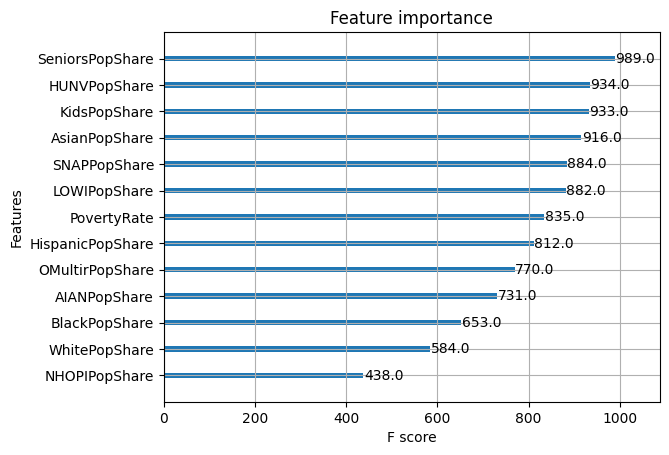

In [35]:
plot_importance(best_model_wo_eng)

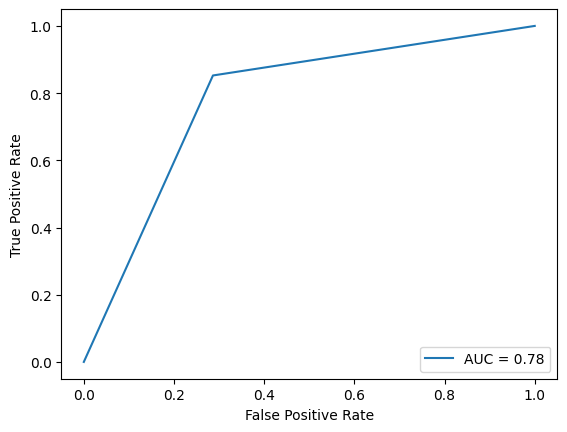

In [53]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

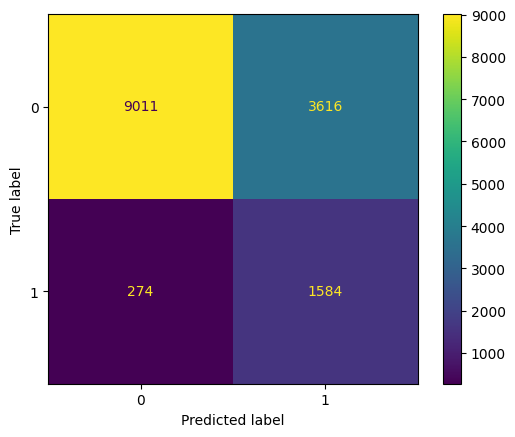

In [54]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

#### Summary of Results and Analysis
Above, I have attempted four models on the data.  Two (Decision Tree Classifier and AdaBoost), we have seein in class, and two attempts at XGBoost models, using grid search to identify the best versions of both models.

I used ROC-AUC as my primary metric because it takes into account both true positive and false positive rates.

For both the standard Decision Tree and AdaBoost, the ROC-AUC score was relatively low.  However, for the XGBoost model with both the Urban/Rural and Census Division features included, the ROC-AUC score was the highest.  For this reason, I would choose the XGBoost model that included the engineered features.  Even though this model is more complex than the one without the engineered features included, it did perform better than the one without.